# Project Four - Indeed Web Scraper

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

---

It is better to test on one page of Indeed rather than parse over multiple at one time.

The next few blocks will be testing and defining functions of my scraper.

In [16]:
# Import scraping and standard libraries
import pandas as pd
import numpy as np
import urllib
from bs4 import BeautifulSoup
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [17]:
# https://www.indeed.com/jobs?q=data+scientist+$20,000&l=New+York&start=30
# $20000 means 20k or up
# l = location
# start increases incrementally by 10. Starting at 00.

In [18]:
# Test one page of url
url = 'https://www.indeed.com/jobs?q=data+scientist&start=00'
html = urllib.urlopen(url).read()
soup = BeautifulSoup(html, 'lxml')

## Function making

Defining all my functions for each feature. Features include:
- Job Title
- Location
- Salary
- Rating
- Number of Reviews
- Summary Prompt

In [19]:
# Trying to get all jobs titles first
job_list = []
for row in soup.find_all('div', {'id':True, 'data-jk':True}):
    jobtitle = row.a.text
#     print jobtitle
    job_list.append(jobtitle)
    
# Convert to function
def job_func(soup, job_list=[]):
    for row in soup.find_all('div', {'id':True, 'data-jk':True}):
        jobtitle = row.a.text
        job_list.append(jobtitle)
    return job_list

In [20]:
# Looking at location
location_list = []
for row in soup.find_all('div', {'id':True}):
    for header in row.find_all('span', {'class':'location'}):
        location = header.text
#         print location
        location_list.append(location)
        
# Convert to function
def loc_func(soup, location_list=[]):
    for row in soup.find_all('div', {'id':True}):
        for header in row.find_all('span', {'class':'location'}):
            location = header.text
            location_list.append(location)
    return location_list

In [21]:
# Looking at salary if there is one
salary_list = []
for row in soup.find_all('div', {'id':True}):
    for block in row.find_all('td', {'class':'snip'}):
        try:
            salary =  block.find('span', {'class':'no-wrap'}).text
#             print salary
            salary_list.append(salary)
        except:
#             print 'no salary info'
            salary_list.append(np.nan)
            
def sal_func(soup, salary_list=[]):
    for row in soup.find_all('div', {'id':True}):
        for block in row.find_all('td', {'class':'snip'}):
            try:
                salary =  block.find('span', {'class':'no-wrap'}).text
                salary_list.append(salary)
            except:
                salary_list.append(np.nan)
                
    return salary_list

In [22]:
# Looking at company
company_list = []
for row in soup.find_all('div', {'id':True}):
    for header in row.find_all('span', {'class':'company'}):
        company_list.append(header.text.replace('\n',''))

def comp_func(soup, company_list=[]):
    for row in soup.find_all('div', {'id':True}):
        for header in row.find_all('span', {'class':'company'}):
            company_list.append(header.text.replace('\n',''))
    return company_list

In [23]:
# Looking at days posted/sponsored. Will specify sponsored as np.nan
# Time is organized by: hours, days, and more than 30 days. 30+ days will be regarded as 30 days
time_list = []
for row in soup.find_all('div', {'id':True}):
    for header in row.find_all('div', {'class':'result-link-bar'}):
        try:
            time =  header.find('span', {'class':'date'}).text
#             print time
            if 'days' in time:
                days = float(time.split()[0])
                time_list.append(round(days,2))
            elif 'hours' in time:
                hours = float(time.split()[0])/24.
                time_list.append(round(hours,2))
            else:
                time_list.append(30.0)
        except:
#             print 'Sponsored'
            time_list.append(np.nan)
            
def time_func(soup, time_list=[]):
    for row in soup.find_all('div', {'id':True}):
        for header in row.find_all('div', {'class':'result-link-bar'}):
            try:
                time =  header.find('span', {'class':'date'}).text
                if 'days' in time:
                    days = float(time.split()[0])
                    time_list.append(days)
                elif 'hours' in time:
                    hours = float(time.split()[0])/24.
                    time_list.append(hours)
                else:
                    time_list.append(30.0)
            except:
                time_list.append(np.nan)
                
    return time_list

In [24]:
# Get summary of job posting
summary_list = []
for row in soup.find_all('div', {'id':True}):
    for header in row.find_all('span', {'class':'summary'}):
        summary_list.append(header.text.replace('\n',''))

def sum_func(soup, summary_list=[]):
    for row in soup.find_all('div', {'id':True}):
        for header in row.find_all('span', {'class':'summary'}):
            summary_list.append(header.text.replace('\n',''))
    return summary_list

In [25]:
# Ratings and number of reviews
rating_list = []
for row in soup.find_all('div', {'id':True, 'data-jk':True}):
    try:
        # Get number of reviews
        ratings = row.find('span', {'class':'slNoUnderline'}).text
        
        # Get actual star count out of 5
        # width is a string with format 'width:##.#px'. Trying to pull out ##.# as a float
        width = row.find('span', {'style':True})['style']
        pixels = re.search('\d{2}.\d',width)
        stars = round(float(pixels.group())/60. * 5, 2)
        rating_list.append((stars, ratings))
        
    except:
        rating_list.append((np.nan, 0))

def rat_func(soup, rating_list=[], star_list=[], review_list=[]):
    for row in soup.find_all('div', {'id':True, 'data-jk':True}):
        try:
            # Get number of reviews
            ratings = row.find('span', {'class':'slNoUnderline'}).text

            # Get actual star count out of 5
            # width is a string with format 'width:##.#px'. Trying to pull out ##.# as a float
            width = row.find('span', {'style':True})['style']
            pixels = re.search('\d{2}.\d',width)
            stars = round(float(pixels.group())/60. * 5, 2)
            rating_list.append((stars, ratings))

        except:
            rating_list.append((np.nan, np.nan))
            
    star_list = [i[0] for i in rating_list]
    review_list = [i[1] for i in rating_list]
            
    return star_list, review_list

### All functions for scraping have been made.
Now, I will create some new 'cleaning' functions to help make the output from the webscraping more human-readable.
I will also create one function that will combine all previous functions and print out into a dataframe.

---

In [26]:
# Got some information, but df is not clean at all. Let's work easiest to hardest. 
# Reviews is first

def cleaner(row):
    try:
        # Replace commas with nothing
        new_row = row.replace(',', '')

        # Get of rid of word 'reviews'
        new_row = float(new_row.split()[0])
    except:
        new_row = np.nan    
    
    return new_row

In [27]:
# Make a cleaner for salary. Taking average of range of salary for computation purposes
# Will return all hourly rates as np.nan, since we are only looking at salaried positions.
def sal_cleaner(row):
    try:
        # Replace commas with nothing
        new_row = row.replace(',', '')

        # Get list of salary split by '-'
        split_list = new_row.split('a year')[0]
        dol_replace = split_list.replace('$', '')
        dol_split = dol_replace.split('-')
        
        if len(dol_split) > 1:
            new_row = 0.5 * (float(dol_split[0]) + float(dol_split[1]))
        else:
            new_row = float(dol_split[0])
    except:
        new_row = np.nan    
    
    return new_row

In [28]:
# We are going to eventually run this above code multiple times. So better to put in a function
def indeed_maker(soup):
    df = pd.DataFrame(zip(job_func(soup), 
                      loc_func(soup), 
                      sal_func(soup), 
                      comp_func(soup), 
                      time_func(soup), 
                      rat_func(soup)[0], 
                      rat_func(soup)[1],
                      sum_func(soup)), 
                  columns=['Title', 
                           'Location', 
                           'Salary',
                           'Company', 
                           'Post_date', 
                           'Rating', 
                           'Reviews',
                           'Summary'])
    
    df.Reviews = df.Reviews.map(cleaner)
    df.Salary = df.Salary.map(sal_cleaner)
    
    return df

### Time to run. Tried to run a while loop, but Indeed cuts off at page 100.
Even if there are more than 100 page worths, Indeed cuts off.
As a result, will have to search through several cities instead of searching without locations.

In [29]:
list_of_cities = ['Atlanta', 'Los+Angeles', 'Seattle', 'Portland', 'San+Francisco', 
                  'Washington%2C+DC', 'Boston', 'Austin', 'Dallas', 'Houston',
                  'Orlando', 'Philadelphia', 'Pittsburgh', 'Cincinnati', 'Miami',
                  'New+York+City', 'New+Jersey', 'Kansas+City', 'San Diego',
                 'San+Jose', 'Salt+Lake+City', 'Raleigh', 'Minneapolis', 'Oklahoma+City',
                 'St.+Louis', 'Detroit', 'Colombus', 'Cleveland', 'Indianapolis', 'Baltimore']

In [30]:
# Looking for two titles
for role in ['research+scientist', 'business+analyst']:
    # Looking at a list of cities
    for city in list_of_cities:
        # Looking through all pages Indeed will allow you to look through
        for page in np.linspace(0, 950, 20):
            # Page indicator
            start = str(int(page))

            # Web initializer
            url = 'https://www.indeed.com/jobs?q=' + role + '&l=' + city + '&limit=50&start=' + start
            html = urllib.urlopen(url).read()
            soup = BeautifulSoup(html, 'lxml')

            # Function that scrapes all relevant data and creates a dataframe        
            ind_df = indeed_maker(soup)
            
            # More pythonic to break for loop if no next link is available. Could not figure out a way.

In [31]:
# Getting rid of row duplicates (sometimes reviews and rating will be different)
ind_df.drop_duplicates(subset=['Summary'], inplace=True)
ind_df.describe()

,Salary,Post_date,Rating,Reviews
count,1036.000000,13650.000000,19281.000000,19281.000000
mean,82382.188224,14.104466,3.961309,1372.266169
std,33269.848269,9.271211,0.507378,3488.319569
min,12530.000000,0.083333,1.250000,2.000000
25%,60000.000000,6.000000,3.600000,38.000000
50%,75500.000000,13.000000,4.250000,240.000000
75%,100000.000000,21.000000,4.350000,736.000000
max,250000.000000,30.000000,5.000000,26371.000000


In [32]:
# Saving dataframe as a csv so that I don't have to run code again.
ind_df.to_csv('Indeed_0621', encoding='utf-8')

# Organize all csv files from several days into one and drop duplicates

Scraped data from several days in hopes of capturing 1000 salaries.
Because csv files were saved, will have to pull from multiple files, concat dataframes, drop duplicates, and finally reset index to get a fresh dataframe to work with.

In [133]:
def read_and_clean(filepath):
    df = pd.read_csv(filepath)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df

empty_df_list = []
paths = ['Indeed_0612', 'Indeed_0615', 'Indeed_0617', 'Indeed_0618', 'Indeed_analyst_0615', 'Indeed_0621']
for filepath in paths:
    empty_df_list.append(read_and_clean(filepath))

df = pd.concat(empty_df_list)

In [134]:
# Cleaning step. Drop duplicates & reset index. 

df.drop_duplicates(['Summary'], inplace=True)

In [135]:
df.head(2)

,Title,Location,Salary,Company,Post_date,Rating,Reviews,Summary
0,Data Scientist,"Arlington, VA 22209",NaN,Deloitte,NaN,4.25,4610.0,Gathering data from both information systems a...
1,Data Scientist,"Durham, NC",NaN,xometry,NaN,NaN,NaN,Xometry is seeking a data scientist to build t...


### Now to perform some EDA.
Will get a general feel for the dataframe and perform any data cleaning that is deemed necessary.

In [136]:
# In the end, I get 1000+ salaries. These may not all be traditional "data scientist/analyst" positions. 
# But it is a good start.

df.describe()

,Salary,Post_date,Rating,Reviews
count,2724.000000,33108.000000,45651.000000,45651.000000
mean,84655.714391,14.039910,3.930274,1557.227421
std,36428.005766,9.716850,0.493395,4736.826192
min,10000.000000,0.083333,1.250000,2.000000
25%,60000.000000,6.000000,3.600000,29.000000
50%,77025.000000,13.000000,4.250000,166.000000
75%,100000.000000,22.000000,4.350000,768.000000
max,275000.000000,30.000000,5.000000,98543.000000


In [654]:
# We want only the observations with salary content. This will help filter out hourly pay jobs.
data = df[df.Salary.notnull()].copy()
data.reset_index(drop=True, inplace=True)

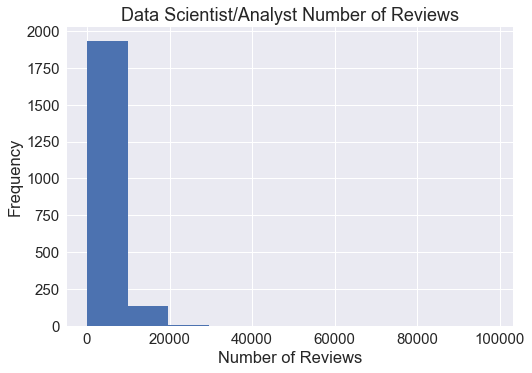

In [596]:
data.Reviews.plot(kind='hist')
plt.title('Data Scientist/Analyst Number of Reviews')
plt.xlabel('Number of Reviews')
plt.show()

In [655]:
# Seems like code was implemented or written incorrectly. Will have to drop whole columns unfortunately.
data.drop('Reviews', axis=1, inplace=True)

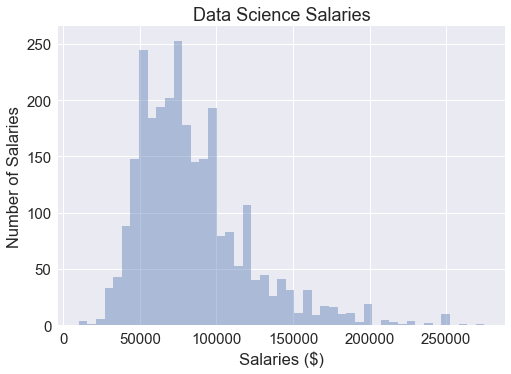

In [598]:
sns.set(font_scale=1.5)
sns.distplot(data.Salary, kde=False)
plt.xlabel('Salaries ($)')
plt.ylabel('Number of Salaries')
plt.title('Data Science Salaries')
plt.show()

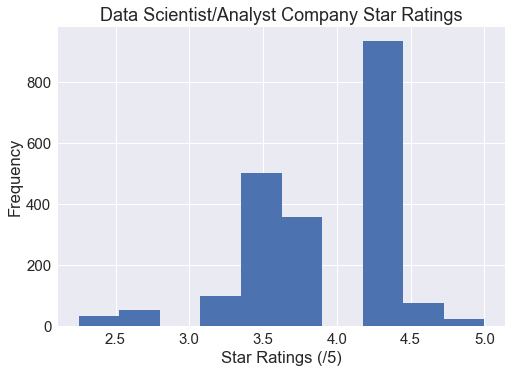

In [599]:
data.Rating.plot(kind='hist')
plt.title('Data Scientist/Analyst Company Star Ratings')
plt.xlabel('Star Ratings (/5)')
plt.show()

In [600]:
data.describe()

,Salary,Post_date,Rating
count,2724.000000,1783.000000,2068.000000
mean,84655.714391,13.697163,3.908535
std,36428.005766,9.591465,0.496936
min,10000.000000,0.083333,2.250000
25%,60000.000000,6.000000,3.600000
50%,77025.000000,12.000000,3.700000
75%,100000.000000,21.000000,4.350000
max,275000.000000,30.000000,5.000000


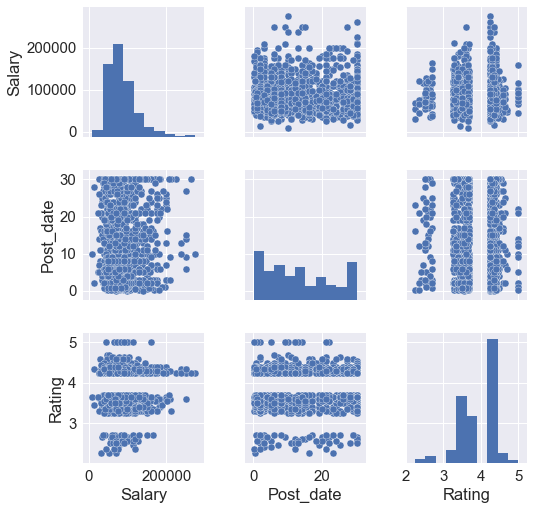

In [601]:
# Pair plot of the numerical data
sns.pairplot(data.dropna())
plt.show()

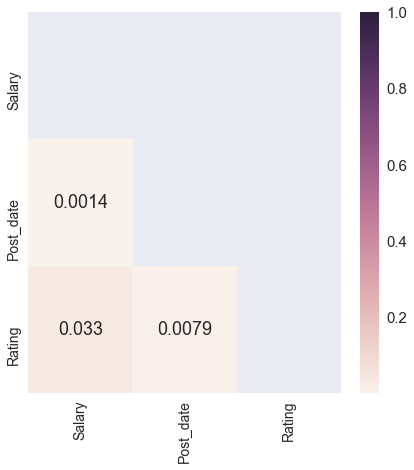

In [602]:
# Set init variables
corr = data[['Salary', 'Post_date', 'Rating']].corr()

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(7,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, annot=True, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation='vertical')
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

---
## Should have labelled cities differently

Will have to relabel cities so that Location data actually represents some useable data.

In [656]:
data.Location.replace(['.+GA.*', '.+NY.*', 'Los Angeles, CA.*', '.+WA.*', '.+OR.*', 'San Francisco.*',
                       '.+DC.*', '.+MA.*', 'Austin, TX.*', 'Dallas, TX.*', 'Houston, TX.*', 'Orlando, FL.*',
                       'Philadelphia, PA.*', 'Pittsburgh, PA.*', 'Cincinatti, OH.*', 'Miami.*',
                       'Kansas City, MO.*', '.+San Diego.*', 'San Jose.*', '.+UT.*', '.+NC.*', '.+MN.*',
                       '.+OK.*', 'St. Louis, MO.*', '.+MI.*', 'Col.mbus, OH.*', 'Cleveland, OH.*', 
                       '.+IN.*', '.+MD.*', '.+NJ.*', '\s\d{5}', '\s\(.*\)', '.+VA.*', '.+SC.*', '.+KS.*', '.+KY.*',
                      '.+IL.*'],
                      ['Atlanta, GA', 'New York, NY', 'Los Angeles, CA', 'Seattle, WA', 'Portland, OR', 'San Francisco, CA',
                       'Washington DC', 'Boston, MA', 'Austin, TX', 'Dallas, TX', 'Houston, TX', 'Orlando, FL',
                       'Philadelphia, PA', 'Pittsburgh, PA', 'Cincinatti, OH', 'Miami, FL', 'Kansas City, MO',
                       'San Diego, CA', 'San Jose, CA', 'Salt Lake City, UT', 'Raleigh, NC', 'Minneapolis, MN',
                       'Oklahoma City, OK', 'St. Louis, MO', 'Detroit, MI', 'Colombus, OH', 'Cleveland, OH', 
                      'Indianapolis, IN', 'Baltimore, MD', 'Newark, NJ', '', '', 'Virginia', 'South Carolina', 
                       'Kansas', 'Kentucky', 'Chicago, IL'], regex=True, inplace=True)

---
### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [713]:
# Import libraries
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, completeness_score, silhouette_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [678]:
# Setting target variable
# Choosing this salary because Glassdoor states this amount as the pay for data scientists in Atlanta
data['High_salary'] = data.Salary.map(lambda x: 0 if x < 90000.0 else 1)

In [679]:
# Evaluating baseline
baseline = max(data.High_salary.mean(), 1-data.High_salary.mean())
print baseline

0.635095447871


In [680]:
# Run a stemmer on Title
snow = SnowballStemmer('english')

placeholder = pd.Series('Title_token')

placeholder.Title_token = data.Title.apply(lambda x: x.decode('utf-8').split(" "))
data['Title_stem'] = placeholder.Title_token.apply(lambda x: " ".join([snow.stem(y) for y in x]))

In [681]:
# First we will split data into a train/test split.
X = data.Title_stem
y = data.High_salary
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=90)

In [682]:
# Do a count vectorizer first
cvec = CountVectorizer(ngram_range=(1,3))
X_train_cv = cvec.fit_transform(X_train)

In [683]:
# Run an SVM model to compare
sv = SVC()
sv.fit(X_train_cv, y_train)
print np.mean(cross_val_score(sv, X_train_cv, y_train, cv=5))
print sv.score(cvec.transform(X_test), y_test)

0.635613202573
0.633027522936


In [684]:
# Going to try several vectorizers and models. Better to write a function that will do this in one step.
def tokenize_test(text, vect, model, target='High_salary', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    '''Arguements are text, vect, model, target (in strings)
    X_train, X_test, y_train, y_test.
    Used to find the accuracy of the High Salary'''
    X = data[text]
    y= data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=90)
    X_train_dtm = vect.fit_transform(X_train)
    
    X_test_dtm = vect.transform(X_test)
    model.fit(X_train_dtm, y_train)
    y_pred_class = model.predict(X_test_dtm)
    return accuracy_score(y_test, y_pred_class)

In [696]:
# Making a dataframe to capture all our accuracy scores
hvec, tvec = HashingVectorizer(), TfidfVectorizer()

Accuracy_scores = []
for model_i, model in enumerate([sv, LogisticRegression(), BernoulliNB(), KNeighborsClassifier()]):
    for vect_i, vect in enumerate([cvec, hvec, tvec]):
        for text in ['Title_stem', 'Location', 'Summary']:
            Accuracy_scores.append((model_i, vect_i, text, tokenize_test(text, vect, model)))

In [697]:
nlp = pd.DataFrame(Accuracy_scores, columns=['Model', 'Vectorizer', 'Column', 'Accuracy_score'])
nlp.Model = nlp.Model.map(lambda x: 'SVC' if x==0 else 'Log' if x==1 else 'Bernoulli' if x==2 else 'KNN')
nlp.Vectorizer = nlp.Vectorizer.map(lambda x: 'CVEC' if x==0 else 'HVEC' if x==1 else 'TVEC')

In [698]:
print 'Accuracy: ', tokenize_test('Location', cvec, RandomForestClassifier())
print 'Accuracy: ', tokenize_test('Location', tvec, RandomForestClassifier())

join1 = ['Random Forest', 'CVEC', 'Location', tokenize_test('Location', cvec, RandomForestClassifier())]
join2 = ['Random Forest', 'TVEC', 'Location', tokenize_test('Location', cvec, RandomForestClassifier())]

nlp.loc[nlp.shape[0]] = join1
nlp.loc[nlp.shape[0]] = join1

Accuracy:  0.656880733945
Accuracy:  0.660550458716


In [699]:
join3 = ['Multinomial', 'CVEC', 'Location', tokenize_test('Location', cvec, MultinomialNB())]
join4 = ['Multinomial', 'CVEC', 'Summary', tokenize_test('Summary', cvec, MultinomialNB())]
join5 = ['Multinomial', 'CVEC', 'Title_stem', tokenize_test('Title_stem', cvec, MultinomialNB())]

join6 = ['Multinomial', 'TVEC', 'Location', tokenize_test('Location', tvec, MultinomialNB())]
join7 = ['Multinomial', 'TVEC', 'Summary', tokenize_test('Summary', tvec, MultinomialNB())]
join8 = ['Multinomial', 'TVEC', 'Title_stem', tokenize_test('Title_stem', tvec, MultinomialNB())]

nlp.loc[nlp.shape[0]] = join3
nlp.loc[nlp.shape[0]] = join4
nlp.loc[nlp.shape[0]] = join5

nlp.loc[nlp.shape[0]] = join6
nlp.loc[nlp.shape[0]] = join7
nlp.loc[nlp.shape[0]] = join8

In [706]:
multiplier = 20
high_nlp = nlp[nlp.Accuracy_score > baseline*(1+(multiplier/100.))].sort_values('Accuracy_score', ascending=False).reset_index(drop=True)
print 'Baseline: ', baseline
high_nlp

Baseline:  0.635095447871


,Model,Vectorizer,Column,Accuracy_score
0,Log,CVEC,Title_stem,0.845872
1,Multinomial,CVEC,Title_stem,0.834862
2,Bernoulli,TVEC,Title_stem,0.805505
3,Multinomial,TVEC,Title_stem,0.801835
4,Log,TVEC,Title_stem,0.794495
5,Bernoulli,CVEC,Title_stem,0.792661
6,Log,HVEC,Title_stem,0.787156


### Feature Extraction
If I don't count the number of words as original features, the dataframe could use some extra help on the number of
features. I will attempt to extract features based on the job titles and summaries. I will make new boolean features
based on whether a certain word appears in the text.

---

In [422]:
# Feature Extractions based on Titles and summaries (if possible)

def text_finder(text_list, title, summary):
    for term in text_list:
        if term.lower() in title.lower() or term.lower() in summary.lower():
            return 1
        else:
            return 0

In [423]:
## Assuming that job summaries are too short to say:
## Title - Entry Level Data Scientist
## Summary - Work with Senior Data Scientist
## My function may be too forgiving and will capture these overlaps

data['Scientist'] = data.apply(lambda row: text_finder(['scientist'], row.Title, row.Summary), axis=1)
data['Analyst'] = data.apply(lambda row: text_finder(['Analyst'], row.Title, row.Summary), axis=1)
data['Senior'] = data.Title.copy().map(lambda x: 1 if 'senior' in x.lower() else 1 if 'sr.' in x.lower() else 0)
data['Entry'] = data.apply(lambda row: text_finder(['entry','junior','jr.'], row.Title, row.Summary), axis=1)
data['Manager'] = data.apply(lambda row: text_finder(['manager', 'mgr.', 'mgr'], row.Title, row.Summary), axis=1)

In [424]:
# Perform countvectorizer on Summary to get the most common words
stop = stopwords.words('english')
stop.extend(['data', 'scientist', 'scientists', 'analyst', 'analysis', 'ability', 'analyze', 'analyzing', 
             'analysts', 'analytics', 'using', 'tools', 'work', 'working', 'including', 'information', 
             'position', 'company', 'knowledge', 'provide', 'quality', 'related', 'reports', 'reporting',
            'science', 'skills', 'services', 'strong'])

cv = CountVectorizer(ngram_range=(1,2), stop_words=stop, max_features=50)

count_df  = pd.DataFrame(cv.fit_transform(data.Summary).todense(),
                   columns=cv.get_feature_names())

In [425]:
count_df.sum().sort_values(ascending=False).head(10)

business      1213
experience     535
research       353
years          262
financial      245
team           238
management     228
senior         227
support        203
systems        197
dtype: int64

In [554]:
# The top non-filler words are:
data['Financial'] = data.apply(lambda row: text_finder(['financial'], row.Title, row.Summary), axis=1)
data['Health'] = data.apply(lambda row: text_finder(['health'], row.Title, row.Summary), axis=1)
data['Machine_learning'] = data.apply(lambda row: text_finder(['machine', 'machine learning'], row.Title, row.Summary), axis=1)
data['SQL'] = data.apply(lambda row: text_finder(['sql'], row.Title, row.Summary), axis=1)
data['Business'] = data.apply(lambda row: text_finder(['business'], row.Title, row.Summary), axis=1)
data['Research'] = data.apply(lambda row: text_finder(['research'], row.Title, row.Summary), axis=1)
data['Experienced'] = data.apply(lambda row: text_finder(['master\'s', '5+', '5-10', '5-7', '7+', 'phd'], row.Title, row.Summary), axis=1)

# One more for skills that a typical data scientist should know
data['Skills'] = data.apply(lambda row: text_finder(['sql', 'model', 'spark', 'hadoop', 'big data', 
                                                    'unix', 'git', 'PCA', 'predict', 'python', ' r ', ' R '
                                                    'statistics', 'stat', 'regression', 'classification',
                                                    'flask', 'database', 'api'], row.Title, row.Summary), axis=1)

In [555]:
# Perform PCA on all these binaries
import patsy
matrix_string = '''
High_salary ~ 
Financial + Health + 
Machine_learning + SQL + 
Scientist + Analyst + Senior + 
Entry + Manager + Skills + 
Business + Research + Experienced -1
'''
y, X = patsy.dmatrices(matrix_string, data)

ss = StandardScaler()
X_ss = ss.fit_transform(X)

binaries_pca = PCA(n_components=5)
binaries_pca.fit(X_ss)
binaries_pca.components_[0]

array([-0.18723586,  0.09966516,  0.28206857, -0.18448145,  0.53562534,
       -0.54933741,  0.01924112, -0.00366501, -0.00292427, -0.18448145,
       -0.37194791,  0.26838911,  0.08912817])

In [556]:
binaries_pca.explained_variance_

array([ 2.14878084,  2.00688571,  1.20516712,  1.13315418,  1.06501664])

In [557]:
trans_binaries = binaries_pca.transform(X_ss)

In [558]:
PCA_df = pd.DataFrame(trans_binaries, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [559]:
lr = LogisticRegression()
lr.fit(trans_binaries, y.ravel())
np.mean(cross_val_score(lr, PCA_df[['PC1', 'PC2', 'PC3', 'PC4']], y.ravel(), cv=5, scoring='accuracy'))

0.71216540744738266

---
### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- **What components of a job posting distinguish data scientists from other data jobs?**
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [433]:
# Make target variable
y_scientist = data.Scientist
X_scientist = data.Summary

Xsci_train, Xsci_test, ysci_train, ysci_test = train_test_split(X_scientist, y_scientist, train_size = .75, random_state=10)

In [446]:
sci_baseline = max(np.mean(y_scientist), 1-np.mean(y_scientist))
print sci_baseline

0.811674008811


In [492]:
Accuracy_scores2 = []
for k_model,v_model in {'SVC':sv, 
                        'Logreg': LogisticRegression(), 
                        'Bernoulli': BernoulliNB(), 
                        'KNN': KNeighborsClassifier()}.items():
    
    for k_vect, v_vect in {'CVEC':cvec, 'HVEC':hvec, 'TVEC':tvec}.items():
        Accuracy_scores2.append((k_model, k_vect, 'Summary', 
                                tokenize_test(text, v_vect, 
                                              v_model, 'Scientist', 
                                              Xsci_train, Xsci_test, 
                                              ysci_train, ysci_test)))

In [493]:
Accuracy_scores3 = []
for k_model,v_model in {'RFC':RandomForestClassifier(), 'Multinomial':MultinomialNB()}.items():
    for k_vect, v_vect in {'CVEC':cvec, 'TVEC':tvec}.items():
        Accuracy_scores3.append((k_model, k_vect, 'Summary', 
                                tokenize_test(text, v_vect, 
                                              v_model, 'Scientist', 
                                              Xsci_train, Xsci_test, 
                                              ysci_train, ysci_test)))

In [499]:
sci_df = pd.DataFrame(Accuracy_scores2, columns=['Model', 
                                                 'Vectorizer', 
                                                 'Column', 
                                                 'Accuracy_score'])

scientist = pd.concat([sci_df, pd.DataFrame(Accuracy_scores3, columns=['Model', 
                                                 'Vectorizer', 
                                                 'Column', 
                                                 'Accuracy_score'])])

scientist.sort_values('Accuracy_score', ascending=False, inplace=True)
scientist.reset_index(drop=True, inplace=True)

In [502]:
print 'Scientist in title/summary baseline: ',sci_baseline
scientist.head()

Scientist in title/summary baseline:  0.811674008811


,Model,Vectorizer,Column,Accuracy_score
0,Logreg,CVEC,Summary,0.919266
1,Logreg,HVEC,Summary,0.906422
2,Bernoulli,TVEC,Summary,0.900917
3,RFC,TVEC,Summary,0.897248
4,Multinomial,CVEC,Summary,0.893578


In [543]:
# Perform PCA on all these binaries
import patsy
matrix_string = '''
Scientist ~ 
Financial + Health + 
Machine_learning + SQL +
Analyst + Senior + 
Entry + Manager + Skills + 
Business + Research + Experienced -1
'''
patsy_y, patsy_X = patsy.dmatrices(matrix_string, data)

Xpat_train, Xpat_test, ypat_train, ypat_test = train_test_split(patsy_X, patsy_y, train_size = .75, random_state=10)

ss = StandardScaler()
Xpat_ss = ss.fit_transform(Xpat_train)
Xpat_ss_test = ss.transform(Xpat_test)

sci_pca = PCA(n_components=5)
sci_pca.fit(Xpat_ss)
sci_pca.components_[0]

array([-0.02038687, -0.0553041 , -0.00946174,  0.69630729,  0.09089502,
        0.00125174, -0.03983589, -0.03312205,  0.69630729,  0.02467594,
       -0.11353687, -0.04797563])

In [544]:
trans_sci = sci_pca.transform(Xpat_ss)
trans_sci_test = sci_pca.transform(Xpat_ss_test)

In [545]:
PCA_sci_df = pd.DataFrame(trans_sci, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
PCA_sci_df_test = pd.DataFrame(trans_sci_test, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [553]:
lr = LogisticRegression()
lr.fit(PCA_sci_df[['PC1', 'PC2', 'PC3']], ypat_train)

print 'Baseline: ', sci_baseline
lr.score(PCA_sci_df_test[['PC1', 'PC2', 'PC3']], ypat_test)

Baseline:  0.811674008811


array(0.8516886930983847)

### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

---
**In other words, higher false negative rate than false positive rate.**

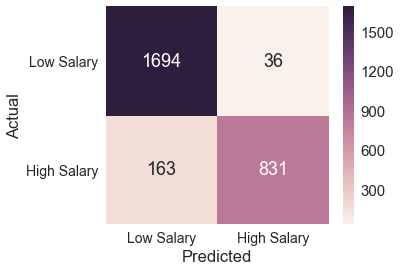

In [761]:
# On test data
X_train_cvc = cvec.fit_transform(X_train)
X_test_cvc = cvec.transform(X_test)
LR = LogisticRegression()
LR.fit(X_train_cvc, y_train)
y_pred = LR.predict(X_test_cvc)
cnf_matrix = confusion_matrix(y_test, y_pred)

# On all data
X_cvc = cvec.transform(X)
LR.fit(X_cvc, y)
y_predicted = LR.predict(X_cvc)
cnf_matrix2 = confusion_matrix(y, y_predicted)

# Conf matrix on all data
fix, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cnf_matrix2, annot=True, fmt='g', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.set_xticklabels(['Low Salary', 'High Salary'], fontsize=14)
ax.set_yticklabels(['High Salary', 'Low Salary'], fontsize=14, rotation='horizontal')
plt.show()

In [765]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def eval_model(model, x_test, y_true):
    y_pred = model.predict(x_test)
    conmat_1 = confusion_matrix(y_true, y_pred, labels=model.classes_)
    conmat_1 = pd.DataFrame(conmat_1, columns=model.classes_, index=model.classes_)
    print('Accuracy Score', accuracy_score(y_true, y_pred))
    print(conmat_1)
    print(classification_report(y_true,y_pred))
    
eval_model(LR, X_cvc, y)

('Accuracy Score', 0.92694566813509549)
      0    1
0  1694   36
1   163  831
             precision    recall  f1-score   support

          0       0.91      0.98      0.94      1730
          1       0.96      0.84      0.89       994

avg / total       0.93      0.93      0.93      2724



In [764]:
from sklearn.metrics import roc_curve, auc

# For class 1, find the area under the curve
fpr, tpr, _ = roc_curve(y_test, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

C:\Users\Chris\Anaconda3\envs\python2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: X has 545 features per sample; expecting 6601